In [41]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   |Tree status in year 1 post-fire. (0=alive, 1=dead). Counted in growing seasons − if fire occurred in spring prior to bud break, 1 year post-fire is that same year as fire. If fire occurred during growing season or fall, 1 year post-fire is the next calendar year after fire.
| YrFireName                  |    A unique identifier for each fire event that includes the year of the fire and the fire name; YEAR - Fire                       
| Times_burned                | The number of times this tree was burned.                                              
| Species                     | Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number. Symbols follow those in the PLANTS National Database (http://plants.usda.gov). 2TREE = unknown tree species.                                                    
| Genus_species               |   Genus and species of tree.                                 
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters). NA = not assessed.
| HT_m                        |Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters). NA = not assessed.
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [4]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

/tmp/ipykernel_1388109/1765753220.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [5]:
trees_dat.info

<bound method DataFrame.info of               YrFireName Species   Dataset  Times_burned        ID Plot  \
0          2006 - Tripod   2TREE  Prichard             1       NaN  188   
1          2006 - Tripod   2TREE  Prichard             1       NaN   74   
2          2006 - Tripod   2TREE  Prichard             1       NaN  193   
3          2006 - Tripod   2TREE  Prichard             1       NaN  126   
4          2006 - Tripod   2TREE  Prichard             1       NaN  113   
...                  ...     ...       ...           ...       ...  ...   
169838  2011 - High Peak    VAAR  McDaniel             1  Pine-oak   52   
169839  2011 - High Peak    VAAR  McDaniel             1    HW mix   25   
169840  2011 - High Peak    VIRU  McDaniel             1  Pine-oak   41   
169841  2011 - High Peak    VIRU  McDaniel             1  Pine-oak    1   
169842  2011 - High Peak    VIRU  McDaniel             1  Pine-oak    1   

       TreeNum Unit      Genus Species_name  ... IPS MPB  RPB  RTB 

In [11]:
# Select columns
trees_dat = trees_dat[['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post']].dropna()

print(trees_dat.info())

trees_dat.dtypes

trees_dat['yr1status'] = pd.to_numeric(trees_dat['yr1status'], downcast='integer')


trees_dat.dtypes


for col in ['YrFireName', 'Species', 'Genus_species']:
    trees_dat[col] = pd.Categorical(trees_dat[col]).codes

<class 'pandas.core.frame.DataFrame'>
Index: 36509 entries, 500 to 169336
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr1status      36509 non-null  int8   
 1   YrFireName     36509 non-null  int8   
 2   Times_burned   36509 non-null  int64  
 3   Species        36509 non-null  int8   
 4   Genus_species  36509 non-null  int8   
 5   DBH_cm         36509 non-null  float64
 6   HT_m           36509 non-null  float64
 7   CR_pre         36509 non-null  float64
 8   CR_post        36509 non-null  float64
dtypes: float64(4), int64(1), int8(4)
memory usage: 1.8 MB
None


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [27]:
# Separate into target and features
X = trees_dat[['YrFireName', 'Times_burned', 'Species', 'Genus_species',
    'DBH_cm', 'HT_m', 'CR_pre', 'CR_post']]
y = trees_dat['yr1status']

# Split and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)




3. How many training/test observations do we have? Print your answer in the cell below. 

In [32]:

# Verify the training and testing set size
print("Training set observations:", X_train_scaled.size)
print("Testing set observations:", X_test_scaled.size)



Training set observations: 204448
Testing set observations: 87624


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [35]:
model = LogisticRegression().fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

print(f"Training Accuracy: ", accuracy_score(y_train_scaled, y_pred))



Training Accuracy:  0.9466812745366566


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy:  0.9466812745366566


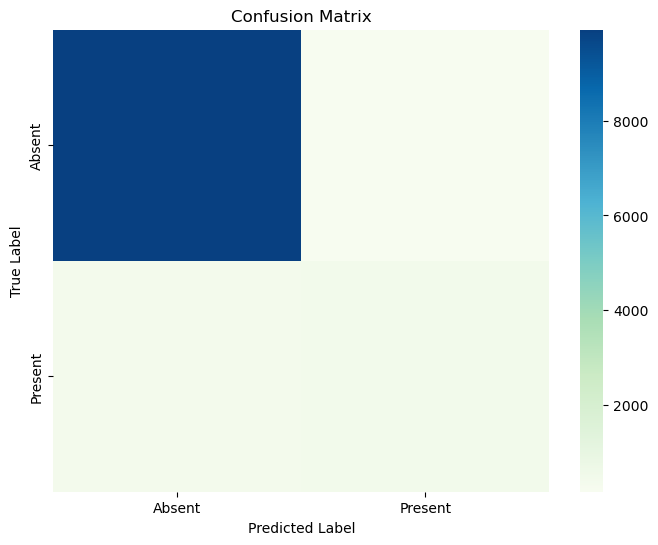

True positives (correctly predicted presence): 445
True negatives (correctly predicted absence): 9924
False positives (incorrectly predicted presence): 162
False negatives (incorrectly predicted absence): 422


Ellipsis

In [43]:


# Print evaluation metrics
print(f"Accuracy: ", accuracy_score(y_test, y_pred))


#Plot confusion matrix
 # Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
    
    # Create confusion matrix plot
plt.figure(figsize = (8,6))
sns.heatmap(cm, fmt = 'd', cmap = 'GnBu',
               xticklabels = ['Absent', 'Present'],
               yticklabels = ['Absent', 'Present'])
plt.title('Confusion Matrix')
plt.ylabel('True Label') 
plt.xlabel('Predicted Label')
plt.show()
    
    # Calculate and display metrics
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
print(f"True positives (correctly predicted presence): {TP}")
print(f"True negatives (correctly predicted absence): {TN}")
print(f"False positives (incorrectly predicted presence): {FP}")
print(f"False negatives (incorrectly predicted absence): {FN}")
...

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

*Your answer here*

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

*Your answer here*

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [ ]:
...

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: ")
print("\nDummy Confusion Matrix:")


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [ ]:
# Logistic classifier AUC
...
print(f"Logistic AUC: ")

In [ ]:
# Dummy classifier AUC
...
print(f"Dummy AUC: ")

# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

*Your answer here*

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [ ]:
...

# Print the sorted feature importance
print(importance_df)

Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

*Your answer here*